In [2]:
import sys
parentdir = 'C:\\Users\\anaxa\\Documents\\Projects\\Synthetic avatar\\BAMT'
sys.path.insert(0,parentdir) 

In [3]:
from openpyxl import load_workbook
import pandas as pd
from datetime import datetime
import numpy as np
from bayesian.train_bn import structure_learning, parameter_learning
from bayesian.save_bn import save_structure, save_params, read_structure, read_params
from external.libpgm.hybayesiannetwork import HyBayesianNetwork
from preprocess.discretization import discretization, get_nodes_type, code_categories, get_nodes_sign
from visualization.visualization import draw_BN, draw_comparative_hist
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
mpl.style.use('seaborn')
from sklearn.cluster import AgglomerativeClustering
from scipy.stats import norm, gamma
from scipy.optimize import minimize
import sknetwork as skn
from sklearn import preprocessing
import math
from bayesian.calculate_accuracy import calculate_acc
from bayesian.sampling import generate_synthetics
from dtaidistance import dtw
from scipy.spatial import distance

In [4]:
act_names = dict()
act_names['Изготовление металоконструкций траверс act'] = 'Изготовление металлоконструкций траверс act'
act_names['Монтаж волоконно-оптического кабеля по металлоконструкциям act'] = 'Монтаж ВОК по металлоконструкциям act'
act_names['Монтаж металоконструкций траверс act'] = 'Монтаж металлоконструкций траверс act'
act_names['Монтаж муфты оптической на опоре 86/1 act'] = 'Монтаж муфты оптической на опоре act'
act_names['Монтаж муфты оптической на опоре сущ1, сущ2 act'] = 'Монтаж муфты оптической на опоре act'
act_names['Монтаж оголовков act'] = 'Монтаж оголовников свай act'
act_names['Монтаж опор (направляющие, скользящие, неподвижные) act'] = 'Монтаж опор act'
act_names['Монтаж опор (направляющие. скользящие. неподвижные) act'] = 'Монтаж опор act'
act_names['Срезка свай (под отметку) act'] = 'Срезка свай act'

In [5]:
res_names = dict()
res_names['Автобетономеситель 6*6 КАМАЗ res'] = 'Автобетоносмеситель res'
res_names['Автокран (25 тн) res'] = 'Автокран res'
res_names['Автокран КС 45721 res'] = 'Автокран res'
res_names['Автомобиль ("Нива", "Петрович") res'] = 'Автомобиль res'
res_names['Автомобиль вахтовый res'] = 'Автомобиль res'
res_names['Бетонщики res'] = 'Бетонщик res'
res_names['Бульдозер САТ Д6 res'] = 'Бульдозер res'
res_names['Бульдозер типа САТ D6 res'] = 'Бульдозер res'
res_names['Бульдозер. трактор res'] = 'Бульдозер res'
res_names['Бурильная машина БМ-811 res'] = 'Бурильная машина res'
res_names['Вахта (Камаз) res'] = 'Вахтовый автомобиль res'
res_names['Газорезчики res'] = 'Газорезчик res'
res_names['ДЭС DENYO 2х пост res'] = 'ДЭС res'
res_names['Изолировщики res'] = 'Изолировщик res'
res_names['Маляры, изолировщики res'] = 'Маляр res'
res_names['Механизаторы. водители res'] = 'Механизаторы res'
res_names['Механик-водитель res'] = 'Механик res'
res_names['Монтажники res'] = 'Монтажник res'
res_names['Разнорабочие res'] = 'Разнорабочий res'
res_names['Руководитель строительства res'] = 'Руководитель res'
res_names['Самосвал (20 тн) res'] = 'Самосвал res'
res_names['Сварочный пост/сварочный аппарат  res'] = 'Сварочный пост res'
res_names['Стропальщики res'] = 'Стропальщик res'
res_names['Трубоукладчик ТР-12.22.02 res'] = 'Трубоукладчик res'
res_names['Экскаватор  гидробур res'] = 'Экскаваторы res'
res_names['Экскаватор  ковш res'] = 'Экскаваторы res'
res_names['Экскаватор РС400 res'] = 'Экскаваторы res'
res_names['Электрик. электромонтажник res'] = 'Электромонтажник res'

In [13]:
df = pd.read_csv('1_fact_work.csv', sep = ';')
df

,Наименование работ,1,2,3,4,5,6,7,8,9,...,53,54,55,56,57,58,59,60,61,62
0,Сварка трубопровода,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Надземная прокладка трубопровода 426х9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Изготовление свай,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Бурение скважин,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Устройство свайного основания,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Срезка свай (под отметку),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Монтаж оголовников свай,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Изготовление металлоконструкций траверс,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Монтаж металлоконструкций траверс,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,"Монтаж опор (направляющие, скользящие, неподви...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
df = df.fillna(0)
df

,Наименование работ,1,2,3,4,5,6,7,8,9,...,53,54,55,56,57,58,59,60,61,62
0,Сварка трубопровода,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Надземная прокладка трубопровода 426х9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Изготовление свай,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Бурение скважин,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Устройство свайного основания,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,Срезка свай (под отметку),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,Монтаж оголовников свай,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,Изготовление металлоконструкций траверс,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,Монтаж металлоконструкций траверс,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,"Монтаж опор (направляющие, скользящие, неподви...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
resource = pd.read_csv('1_fact_res.csv', sep=';')
resource = resource.drop(index=[33, 34, 35, 36, 37, 38])
resource

,Ресурсы,1,2,3,4,5,6,7,8,9,...,53,54,55,56,57,58,59,60,61,62
0,Руководитель строительства,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
1,Инженер технического надзора,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
2,Геодезист,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Инженер по охране труда,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
4,Инженер ПТО,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
5,Начальник участка,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
6,Прораб,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
7,Мастер СМР,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
8,Кладовщик,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
9,Механизаторы,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
resource = resource.fillna(0)
resource

,Ресурсы,1,2,3,4,5,6,7,8,9,...,53,54,55,56,57,58,59,60,61,62
0,Руководитель строительства,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Инженер технического надзора,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Геодезист,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Инженер по охране труда,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Инженер ПТО,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,Начальник участка,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,Прораб,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,Мастер СМР,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,Кладовщик,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,Механизаторы,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
dates_works = pd.date_range(datetime.strptime('2017-03-01', "%Y-%m-%d"), periods=31).tolist() + pd.date_range(datetime.strptime('2017-05-01', "%Y-%m-%d"), periods=31).tolist()
df.columns = ['Работа' ] + dates_works

In [19]:
dates_res = pd.date_range(datetime.strptime('2017-03-01', "%Y-%m-%d"), periods=31).tolist() + pd.date_range(datetime.strptime('2017-05-01', "%Y-%m-%d"), periods=31).tolist()

In [20]:
resource.columns = ['Ресурсы'] + dates_res
resource

,Ресурсы,2017-03-01 00:00:00,2017-03-02 00:00:00,2017-03-03 00:00:00,2017-03-04 00:00:00,2017-03-05 00:00:00,2017-03-06 00:00:00,2017-03-07 00:00:00,2017-03-08 00:00:00,2017-03-09 00:00:00,...,2017-05-22 00:00:00,2017-05-23 00:00:00,2017-05-24 00:00:00,2017-05-25 00:00:00,2017-05-26 00:00:00,2017-05-27 00:00:00,2017-05-28 00:00:00,2017-05-29 00:00:00,2017-05-30 00:00:00,2017-05-31 00:00:00
0,Руководитель строительства,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Инженер технического надзора,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Геодезист,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Инженер по охране труда,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Инженер ПТО,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,Начальник участка,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,Прораб,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,Мастер СМР,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,Кладовщик,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,Механизаторы,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
df

,Работа,2017-03-01 00:00:00,2017-03-02 00:00:00,2017-03-03 00:00:00,2017-03-04 00:00:00,2017-03-05 00:00:00,2017-03-06 00:00:00,2017-03-07 00:00:00,2017-03-08 00:00:00,2017-03-09 00:00:00,...,2017-05-22 00:00:00,2017-05-23 00:00:00,2017-05-24 00:00:00,2017-05-25 00:00:00,2017-05-26 00:00:00,2017-05-27 00:00:00,2017-05-28 00:00:00,2017-05-29 00:00:00,2017-05-30 00:00:00,2017-05-31 00:00:00
0,Сварка трубопровода,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Надземная прокладка трубопровода 426х9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Изготовление свай,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Бурение скважин,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Устройство свайного основания,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,Срезка свай (под отметку),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,Монтаж оголовников свай,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,Изготовление металлоконструкций траверс,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,Монтаж металлоконструкций траверс,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,"Монтаж опор (направляющие, скользящие, неподви...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
df.set_index('Работа', inplace=True)
df

,2017-03-01,2017-03-02,2017-03-03,2017-03-04,2017-03-05,2017-03-06,2017-03-07,2017-03-08,2017-03-09,2017-03-10,...,2017-05-22,2017-05-23,2017-05-24,2017-05-25,2017-05-26,2017-05-27,2017-05-28,2017-05-29,2017-05-30,2017-05-31
Работа,,,,,,,,,,,,,,,,,,,,,
Сварка трубопровода,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Надземная прокладка трубопровода 426х9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Изготовление свай,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Бурение скважин,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Устройство свайного основания,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Срезка свай (под отметку),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Монтаж оголовников свай,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Изготовление металлоконструкций траверс,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Монтаж металлоконструкций траверс,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
df = np.transpose(df)

In [24]:
df

Работа,Сварка трубопровода,Надземная прокладка трубопровода 426х9,Изготовление свай,Бурение скважин,Устройство свайного основания,Срезка свай (под отметку),Монтаж оголовников свай,Изготовление металлоконструкций траверс,Монтаж металлоконструкций траверс,"Монтаж опор (направляющие, скользящие, неподвижные)",Сварка трубопровода,Надземная прокладка трубопровода 426х9,Вертикальная планировка,Устройство подъезда,Устройство покрытия подъездов,Инженерная подготовка,Устройство покрытия подъездов
2017-03-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-03-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-03-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-03-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-03-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-05-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-05-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-05-29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-05-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:

for c in df.columns.tolist():
    df[c] = df[c].astype(int)

In [26]:
df.columns = [x + ' act' for x in df.columns]

In [27]:
resource.set_index('Ресурсы', inplace=True)
resource

,2017-03-01,2017-03-02,2017-03-03,2017-03-04,2017-03-05,2017-03-06,2017-03-07,2017-03-08,2017-03-09,2017-03-10,...,2017-05-22,2017-05-23,2017-05-24,2017-05-25,2017-05-26,2017-05-27,2017-05-28,2017-05-29,2017-05-30,2017-05-31
Ресурсы,,,,,,,,,,,,,,,,,,,,,
Руководитель строительства,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Инженер технического надзора,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Геодезист,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Инженер по охране труда,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Инженер ПТО,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Начальник участка,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Прораб,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Мастер СМР,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Кладовщик,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
resource = np.transpose(resource)
resource

Ресурсы,Руководитель строительства,Инженер технического надзора,Геодезист,Инженер по охране труда,Инженер ПТО,Начальник участка,Прораб,Мастер СМР,Кладовщик,Механизаторы,...,Автокран (25 тн),Бурильная машина БМ-811,ППУ,Тягач с полуприцепом,Самосвал (20 тн),Экскаватор РС400,Бульдозер САТ Д6,АГП,Автобетоносмеситель,А/м для перевозки воды
2017-03-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-03-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-03-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-03-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-03-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-05-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-05-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-05-29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-05-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
for c in resource.columns.tolist():
    resource[c] = resource[c].astype(int)

In [30]:
resource.columns = [x + ' res' for x in resource.columns]



In [31]:
df = df.rename_axis(None, axis=1)
df

,Сварка трубопровода act,Надземная прокладка трубопровода 426х9 act,Изготовление свай act,Бурение скважин act,Устройство свайного основания act,Срезка свай (под отметку) act,Монтаж оголовников свай act,Изготовление металлоконструкций траверс act,Монтаж металлоконструкций траверс act,"Монтаж опор (направляющие, скользящие, неподвижные) act",Сварка трубопровода act,Надземная прокладка трубопровода 426х9 act,Вертикальная планировка act,Устройство подъезда act,Устройство покрытия подъездов act,Инженерная подготовка act,Устройство покрытия подъездов act
2017-03-01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2017-03-02,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2017-03-03,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2017-03-04,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2017-03-05,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-05-27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2017-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2017-05-29,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2017-05-30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [32]:
df = df.sum(axis=1, level=0)

C:\Users\anaxa\AppData\Local\Temp/ipykernel_884/372834575.py:1: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  df = df.sum(axis=1, level=0)


In [33]:
new_columns = []
for c in df.columns:
    if c in act_names.keys():
        new_columns.append(act_names[c])
    else:
        new_columns.append(c)


df.columns = new_columns
df = df.sum(axis=1, level=0)

C:\Users\anaxa\AppData\Local\Temp/ipykernel_884/599436417.py:10: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  df = df.sum(axis=1, level=0)


In [34]:
resource = resource.rename_axis(None, axis=1)
resource

,Руководитель строительства res,Инженер технического надзора res,Геодезист res,Инженер по охране труда res,Инженер ПТО res,Начальник участка res,Прораб res,Мастер СМР res,Кладовщик res,Механизаторы res,...,Автокран (25 тн) res,Бурильная машина БМ-811 res,ППУ res,Тягач с полуприцепом res,Самосвал (20 тн) res,Экскаватор РС400 res,Бульдозер САТ Д6 res,АГП res,Автобетоносмеситель res,А/м для перевозки воды res
2017-03-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2017-03-02,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2017-03-03,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2017-03-04,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2017-03-05,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-05-27,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2017-05-28,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2017-05-29,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2017-05-30,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [35]:
resource = resource.sum(axis=1, level=0)

C:\Users\anaxa\AppData\Local\Temp/ipykernel_884/1076265461.py:1: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  resource = resource.sum(axis=1, level=0)


In [36]:
new_columns = []
for c in resource.columns:
    if c in res_names.keys():
        new_columns.append(res_names[c])
    else:
        new_columns.append(c)


resource.columns = new_columns
resource = resource.sum(axis=1, level=0)

C:\Users\anaxa\AppData\Local\Temp/ipykernel_884/1966811535.py:10: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  resource = resource.sum(axis=1, level=0)


In [37]:
final_df = pd.concat([df, resource], axis=1)
len(final_df.columns)

47

In [38]:
final_df

,Сварка трубопровода act,Надземная прокладка трубопровода 426х9 act,Изготовление свай act,Бурение скважин act,Устройство свайного основания act,Срезка свай act,Монтаж оголовников свай act,Изготовление металлоконструкций траверс act,Монтаж металлоконструкций траверс act,Монтаж опор act,...,Автокран res,Бурильная машина res,ППУ res,Тягач с полуприцепом res,Самосвал res,Экскаваторы res,Бульдозер res,АГП res,Автобетоносмеситель res,А/м для перевозки воды res
2017-03-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2017-03-02,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2017-03-03,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2017-03-04,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2017-03-05,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-05-27,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2017-05-28,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2017-05-29,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2017-05-30,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [40]:
final_df.to_csv('file1_fact.csv')

In [421]:
df_1 = pd.read_csv('1.csv')
df_2 = pd.read_csv('2.csv')
df_3 = pd.read_csv('3.csv')
df_4 = pd.read_csv('4.csv')
df_5 = pd.read_csv('5.csv')
df_6 = pd.read_csv('6.csv')

In [374]:
set1 = set(df_1.columns.tolist())
set2 = set(df_2.columns.tolist())
set3 = set(df_3.columns.tolist())
set4 = set(df_4.columns.tolist())
set5 = set(df_5.columns.tolist())
set6 = set(df_6.columns.tolist())

In [405]:
nodes_type = get_nodes_type(df_6)

In [770]:
df_6 = df_6.drop(columns=['Unnamed: 0'])

In [410]:
# black_list = []
# for c1 in final_df.columns.tolist():
#     for c2 in final_df.columns.tolist():
#         if (c1 != c2) & (c1.split()[-1] == 'act') & (c2.split()[-1] == 'res'):
#             black_list.append((c1, c2))
#             black_list.append((c2, c1))
df_6_act = df_6[[c for c in df_6.columns if c.split()[-1] == 'act']]

bn = structure_learning(df_6_act, search='HC', node_type=nodes_type, score='K2')

In [338]:
for key in nodes_type.keys():
    if key.split()[-1] == 'act':
        nodes_type[key] = 'cont'


In [771]:
df_act = df_6[[c for c in df_6.columns if c.split()[-1] == 'act']]
df_res = df_6[[c for c in df_6.columns if c.split()[-1] == 'res']]

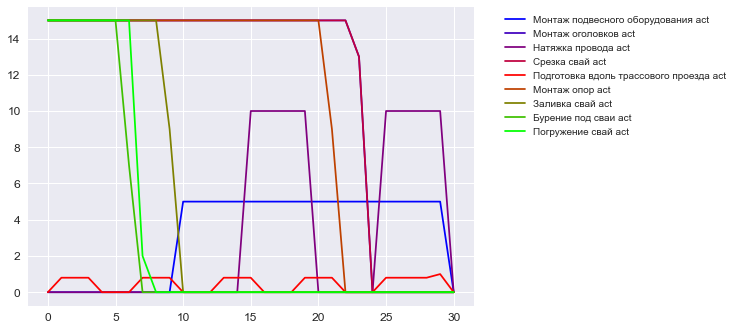

In [480]:
df_act.plot(fontsize=12, colormap='brg')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')


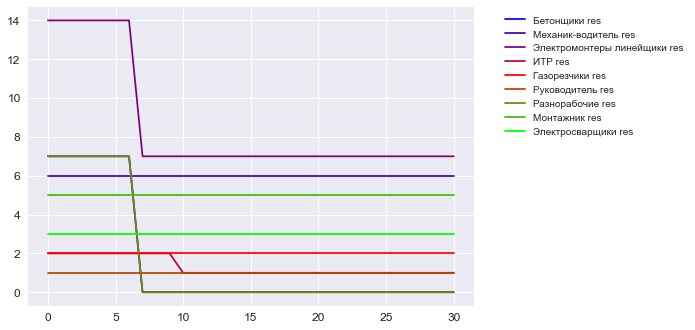

In [481]:
df_res.plot(fontsize=12, colormap='brg')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')


<AxesSubplot:>

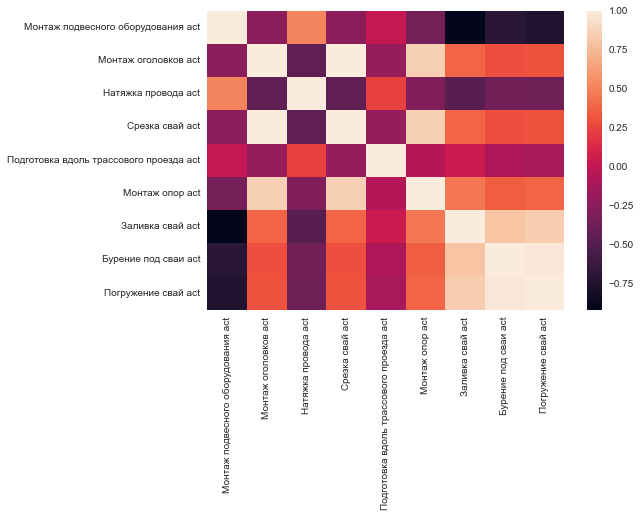

In [772]:
corr_meat = df_act.corr(method='pearson')
sns.heatmap(corr_meat)
        #    annot=True,
        #    linewidths=0.4,
        #    annot_kws={'size': 10})

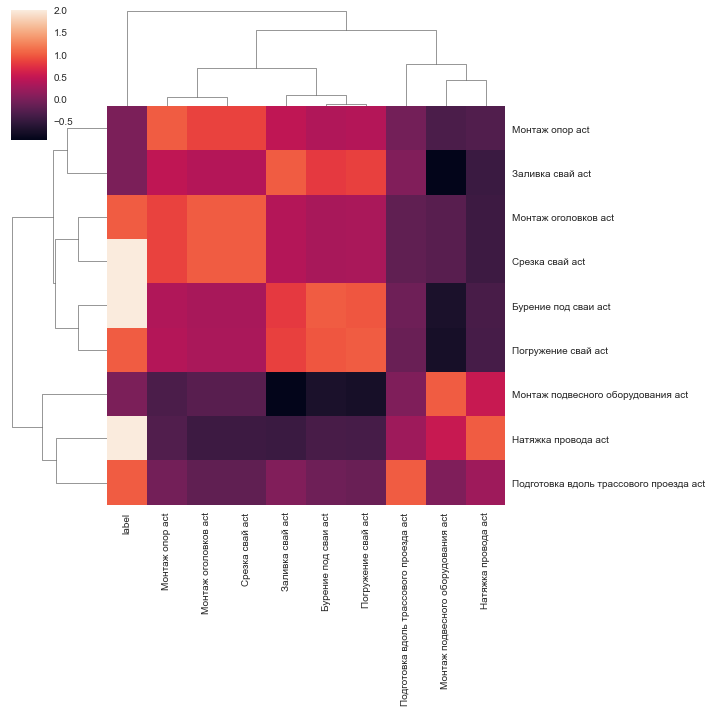

In [810]:
sns.clustermap(corr_meat)

In [773]:

clustering = AgglomerativeClustering(n_clusters=3,affinity='precomputed', linkage = 'complete').fit(corr_meat.values)

In [774]:
corr_meat['label'] = clustering.labels_
corr_meat.loc[corr_meat['label'] == 0].index

Index(['Монтаж подвесного оборудования act', 'Монтаж опор act',
       'Заливка свай act'],
      dtype='object')

In [775]:
corr_meat.loc[corr_meat['label'] == 1].index

Index(['Монтаж оголовков act', 'Подготовка вдоль трассового проезда act',
       'Погружение свай act'],
      dtype='object')

In [776]:
corr_meat.loc[corr_meat['label'] == 2].index

Index(['Натяжка провода act', 'Срезка свай act', 'Бурение под сваи act'], dtype='object')

In [777]:
column1 = corr_meat.loc[corr_meat['label'] == 0].index.tolist() + df_res.columns.tolist()
column2 = corr_meat.loc[corr_meat['label'] == 1].index.tolist() + df_res.columns.tolist()
column3 = corr_meat.loc[corr_meat['label'] == 2].index.tolist() + df_res.columns.tolist()

In [778]:
df_cluster1 = df_6[column1]
df_cluster2 = df_6[column2]
df_cluster3 = df_6[column3]

In [779]:
nodes_type = get_nodes_type(df_6)

In [780]:
white_list = []
for c1 in df_6.columns.tolist():
    for c2 in df_6.columns.tolist():
        if (c1 != c2) & (c1.split()[-1] == 'act') & (c2.split()[-1] == 'res'):
            white_list.append((c1, c2))
            white_list.append((c2, c1))

In [803]:
bn = structure_learning(df_cluster3, search='HC', node_type=nodes_type, score='K2', white_list=white_list)

In [784]:
le = preprocessing.LabelEncoder()
le.fit(df_6.columns)

LabelEncoder()

In [804]:
edges = []
for e in bn['E']:
    edges.append(le.transform(e))

In [805]:
edges

[array([ 1, 16]),
 array([ 1, 13]),
 array([1, 0]),
 array([1, 4]),
 array([ 4, 10]),
 array([ 4, 15])]

In [806]:
adjacency = skn.utils.edgelist2adjacency(edges)

In [807]:
df_matrix = pd.DataFrame(columns=le.classes_[0:17], data = adjacency.toarray())
df_matrix.index = columns=le.classes_[0:17]

In [758]:
df_matrix = pd.DataFrame(columns=le.classes_, data = np.full((len(le.classes_), len(le.classes_)), False))
df_matrix.index = columns=le.classes_

In [808]:
df_matrix

,Бетонщики res,Бурение под сваи act,Газорезчики res,Заливка свай act,ИТР res,Механик-водитель res,Монтаж оголовков act,Монтаж опор act,Монтаж подвесного оборудования act,Монтажник res,Натяжка провода act,Погружение свай act,Подготовка вдоль трассового проезда act,Разнорабочие res,Руководитель res,Срезка свай act,Электромонтеры линейщики res
Бетонщики res,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
Бурение под сваи act,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,True
Газорезчики res,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
Заливка свай act,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
ИТР res,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False
Механик-водитель res,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
Монтаж оголовков act,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
Монтаж опор act,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
Монтаж подвесного оборудования act,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
Монтажник res,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [809]:
df_matrix.to_csv('matrix18.csv')

In [812]:
unique_columns = []
for i in range(1, 19, 1):
    data = pd.read_csv('matrix'+str(i)+'.csv')
    data = data.drop(columns=['Unnamed: 0'])
    for c in data.columns.tolist():
        if c not in unique_columns:
            unique_columns.append(c)


In [832]:
node_net = pd.DataFrame(data=np.zeros((163, 18)), columns=['net1', 'net2', 'net3', 'net4', 'net5', 'net6', 'net7', 'net8', 'net9', 'net10', 'net11', 'net12', 'net13', 'net14', 'net15', 'net16', 'net17', 'net18'])
node_net.index = unique_columns
for i in range(1, 19, 1):
    data = pd.read_csv('matrix'+str(i)+'.csv')
    data.index = data['Unnamed: 0']
    data = data.drop(columns=['Unnamed: 0'])
    for c in data.columns.tolist():
        if ((data[c] == True).any()) | ((data.loc[c,:] == True).any()):
            node_net.loc[c,'net'+str(i)] = 1



In [835]:
act = []
res = []
for c in unique_columns:
    if c.split()[-1] == 'act':
        act.append(c)
    else:
        res.append(c)


In [839]:
brave = pd.DataFrame(data=np.zeros((len(act), len(res))), columns=res)
brave.index = act
brave

,А/м для перевозки воды res,АГП res,Автобетоносмеситель res,Автокран (25 тн) res,Автомобиль вахтовый res,Бульдозер САТ Д6 res,Бурильная машина БМ-811 res,Газорезчик res,Геодезист res,ДЭС res,...,Водитель res,КамАЗ грузовой фургон res,Монтажник связи res,Хищник res,Бетонщики res,Газорезчики res,Механик-водитель res,Разнорабочие res,Руководитель res,Электромонтеры линейщики res
Бурение скважин act,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Вертикальная планировка act,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Изготовление металлоконструкций траверс act,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Изготовление свай act,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Инженерная подготовка act,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Монтаж опор act,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Монтаж подвесного оборудования act,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Натяжка провода act,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Подготовка вдоль трассового проезда act,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [842]:
node_net

,net1,net2,net3,net4,net5,net6,net7,net8,net9,net10,net11,net12,net13,net14,net15,net16,net17,net18
А/м для перевозки воды res,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
АГП res,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Автобетоносмеситель res,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Автокран (25 тн) res,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Автомобиль вахтовый res,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Подготовка вдоль трассового проезда act,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Разнорабочие res,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
Руководитель res,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Срезка свай act,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [855]:
for c1 in act:
    for c2 in res:
        print(c1)
        print(c2)
        print('---------------------------------')

        a = 0
        b = 0
        c = 0
        d = 0
        for i in range(1,19, 1):
            if (node_net.loc[c1,'net'+str(i)] == 1) & (node_net.loc[c2,'net'+str(i)] == 1):
                a += 1
            if (node_net.loc[c1,'net'+str(i)] == 1) & (node_net.loc[c2,'net'+str(i)] == 0):
                b += 1
            if (node_net.loc[c1,'net'+str(i)] == 0) & (node_net.loc[c2,'net'+str(i)] == 1):
                c += 1
            if (node_net.loc[c1,'net'+str(i)] == 0) & (node_net.loc[c2,'net'+str(i)] == 0):
                d += 1
        if (a == 0) & (c == 0):
            a = 0.0001
        if (b == 0) & (d == 0):
            b = 0.0001
        if (a == 0) & (b == 0):
            a = 0.0001
        if (d == 0) & (c == 0):
            d = 0.0001
        br = (a*18 + (a + c)*(a + b)) / (math.sqrt((a+c)*(b+d)) * math.sqrt((a+b)*(c+d)))
        brave.loc[c1,c2] = br

        

Бурение скважин act
А/м для перевозки воды res
---------------------------------
Бурение скважин act
АГП res
---------------------------------
Бурение скважин act
Автобетоносмеситель res
---------------------------------
Бурение скважин act
Автокран (25 тн) res
---------------------------------
Бурение скважин act
Автомобиль вахтовый res
---------------------------------
Бурение скважин act
Бульдозер САТ Д6 res
---------------------------------
Бурение скважин act
Бурильная машина БМ-811 res
---------------------------------
Бурение скважин act
Газорезчик res
---------------------------------
Бурение скважин act
Геодезист res
---------------------------------
Бурение скважин act
ДЭС res
---------------------------------
Бурение скважин act
ИТР res
---------------------------------
Бурение скважин act
Инженер ПТО res
---------------------------------
Бурение скважин act
Инженер по охране труда res
---------------------------------
Бурение скважин act
Инженер технического надзора res
---

C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8960 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8960 missing from current font.
  font.set_text(s, 0, flags=flags)


<AxesSubplot:>

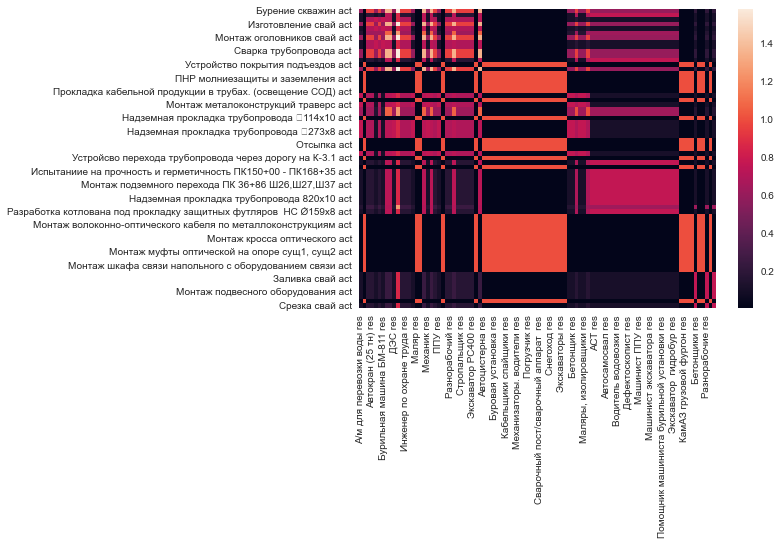

In [857]:
sns.heatmap(brave)

In [863]:
frequency_df = pd.DataFrame(data=np.zeros((len(act), len(res))), columns=res)
frequency_df.index = act
for c1 in act:
    for c2 in res:
        count = 0
        for i in range(1, 19, 1):
            data = pd.read_csv('matrix'+str(i)+'.csv')
            data.index = data['Unnamed: 0']
            data = data.drop(columns=['Unnamed: 0'])
            if (c1 in data.columns) & (c2 in data.columns):
                if (data.loc[c1,c2] == True) | (data.loc[c2,c1] == True):
                    count += 1
        frequency_df.loc[c1, c2] = count / 18



<AxesSubplot:>

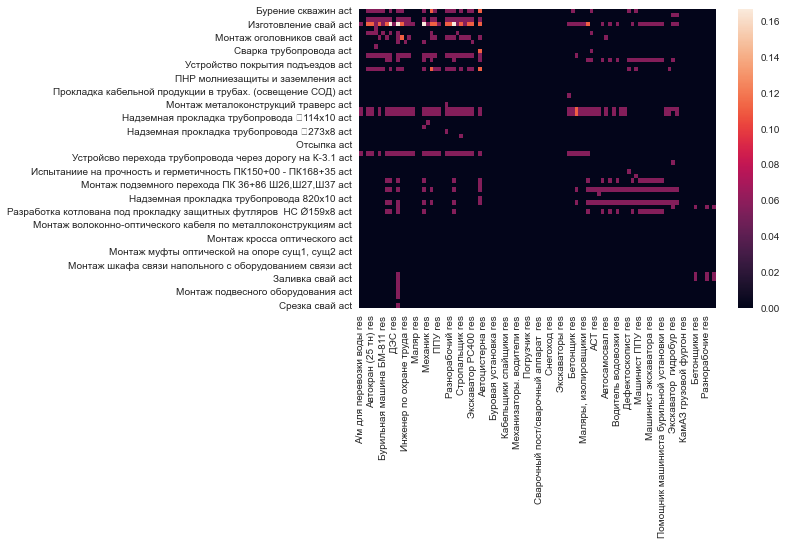

In [864]:
sns.heatmap(frequency_df)

In [18]:
df1 = pd.read_csv('3.csv')
df1 = df1.drop(columns=['Unnamed: 0'])


In [19]:
df_distance = pd.DataFrame(data=np.zeros((len(df1.columns), len(df1.columns))), columns=df1.columns.tolist())
df_distance.index = df1.columns.tolist()

In [23]:
for c1 in df1.columns:
    for c2 in df1.columns:
        print(c1)
        print(c2)
        print('------------')
        dis = distance.euclidean(df1[c1].values, df1[c2].values)
        df_distance.loc[c1,c2] = dis


Устройство свайного основания act
Устройство свайного основания act
------------
Устройство свайного основания act
Монтаж металоконструкций траверс act
------------
Устройство свайного основания act
Сварка трубопровода act
------------
Устройство свайного основания act
Испытание трубопровода act
------------
Устройство свайного основания act
Монтаж оголовников свай act
------------
Устройство свайного основания act
Отсыпка act
------------
Устройство свайного основания act
Надземная прокладка трубопровода ⌀325х8 act
------------
Устройство свайного основания act
Надземная прокладка трубопровода act
------------
Устройство свайного основания act
Надземная прокладка трубопровода ⌀168х14 act
------------
Устройство свайного основания act
Монтаж опор (направляющие, скользящие, неподвижные) act
------------
Устройство свайного основания act
Устройсво перехода трубопровода через дорогу на К-3.1 act
------------
Устройство свайного основания act
Надземная прокладка трубопровода ⌀426х9 act
---

C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8960 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8960 missing from current font.
  font.set_text(s, 0, flags=flags)


<AxesSubplot:>

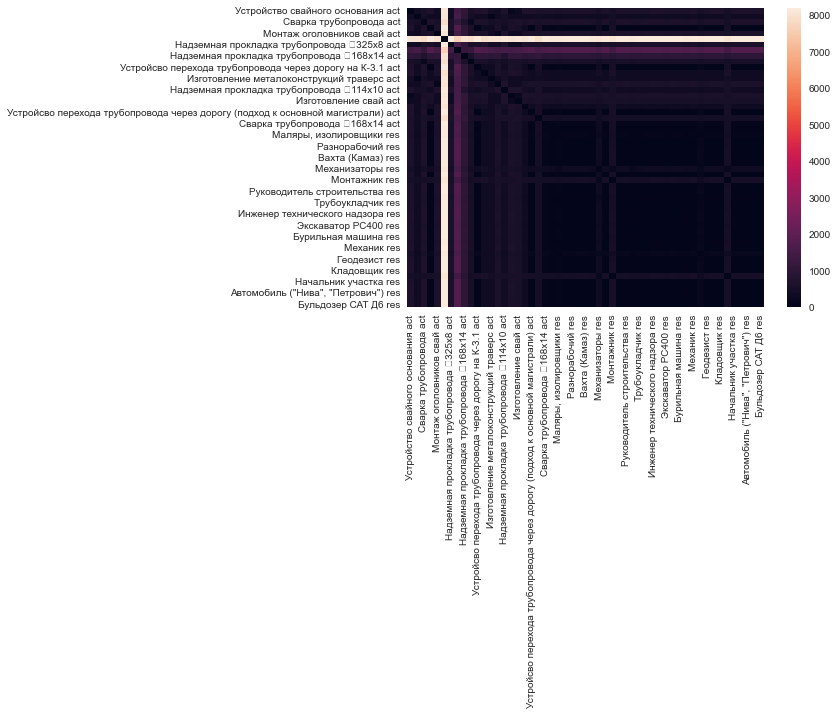

In [24]:
sns.heatmap(df_distance)

C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8960 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8960 missing from current font.
  font.set_text(s, 0, flags=flags)


<AxesSubplot:>

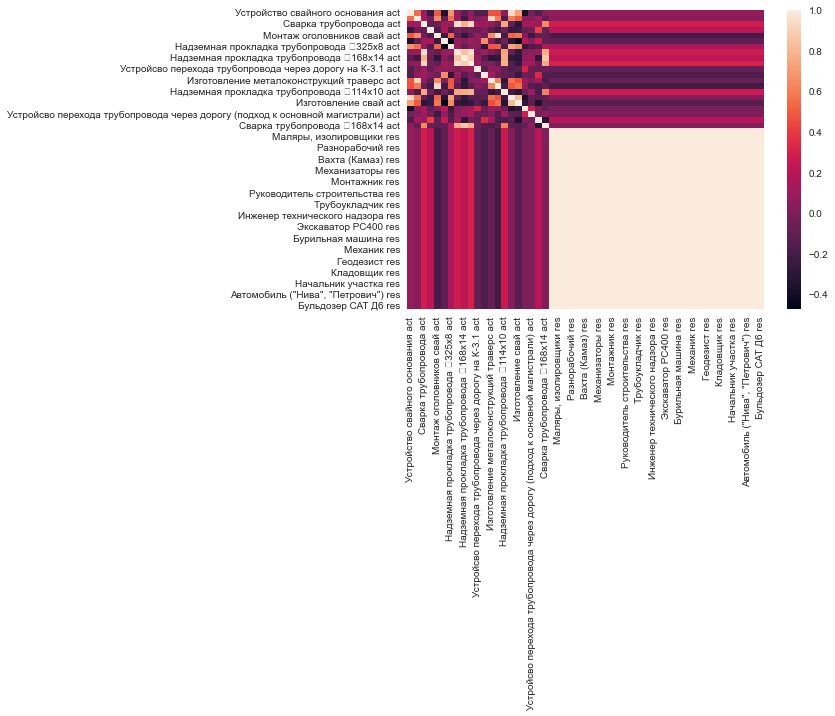

In [4]:
corr = df1.corr()
sns.heatmap(corr)

In [3]:
df_act = df1[[c for c in df1.columns if c.split()[-1] == 'act']]
df_res = df1[[c for c in df1.columns if c.split()[-1] == 'res']]

In [4]:
corr = df_act.corr(method='pearson')
clustering = AgglomerativeClustering(n_clusters=3,affinity='precomputed', linkage = 'complete').fit(corr.values)

In [5]:
corr['labels'] = clustering.labels_

In [6]:
column1 = corr.loc[corr['labels'] == 0].index.tolist()
column2 = corr.loc[corr['labels'] == 1].index.tolist() 
column3 = corr.loc[corr['labels'] == 2].index.tolist() 

In [7]:
df_final = pd.DataFrame(columns=['Act', 'Cluster']+df_res.columns.tolist())


In [8]:
for c in df_act.columns.tolist():
    cluster = 0
    if c in column1:
        cluster = 1
    if c in column2:
        cluster = 2
    if c in column3:
        cluster = 3
    act_index = []
    for i in range(df1.shape[0]):
        if df1.loc[i,c] != 0:
            act_index.append(i)
    mean_res = dict(df_res.iloc[act_index,:].mean(axis=0))
    d1 = {'Act':c, 'Cluster':cluster}
    d1.update(mean_res)
    df_final = df_final.append(d1, ignore_index=True)

    
    

In [9]:
df_final

,Act,Cluster,Руководитель строительства res,Инженер технического надзора res,Геодезист res,Инженер по охране труда res,Инженер ПТО res,Начальник участка res,Прораб res,Мастер СМР res,...,Автокран (25 тн) res,Бурильная машина БМ-811 res,ППУ res,Тягач с полуприцепом res,Самосвал (20 тн) res,Экскаватор РС400 res,Бульдозер САТ Д6 res,АГП res,Автобетоносмеситель res,А/м для перевозки воды res
0,Сварка трубопровода act,2,2.000000,1.0,2.000000,1.0,2.000000,2.000000,2.000000,0.0,...,2.000000,2.000000,0.0,4.000000,2.0,4.000000,2.000000,0.0,4.000000,0.0
1,Надземная прокладка трубопровода 426х9 act,2,2.000000,1.0,2.000000,1.0,2.000000,2.000000,2.000000,0.0,...,2.000000,2.000000,0.0,4.000000,2.0,4.000000,2.000000,0.0,4.000000,0.0
2,Изготовление свай act,3,1.451613,1.0,1.451613,1.0,1.451613,1.451613,1.451613,0.0,...,1.451613,1.451613,0.0,2.903226,2.0,2.903226,1.451613,0.0,2.903226,0.0
3,Бурение скважин act,2,1.451613,1.0,1.451613,1.0,1.451613,1.451613,1.451613,0.0,...,1.451613,1.451613,0.0,2.903226,2.0,2.903226,1.451613,0.0,2.903226,0.0
4,Устройство свайного основания act,1,1.451613,1.0,1.451613,1.0,1.451613,1.451613,1.451613,0.0,...,1.451613,1.451613,0.0,2.903226,2.0,2.903226,1.451613,0.0,2.903226,0.0
5,Срезка свай (под отметку) act,2,2.000000,1.0,2.000000,1.0,2.000000,2.000000,2.000000,0.0,...,2.000000,2.000000,0.0,4.000000,2.0,4.000000,2.000000,0.0,4.000000,0.0
6,Монтаж оголовников свай act,1,2.000000,1.0,2.000000,1.0,2.000000,2.000000,2.000000,0.0,...,2.000000,2.000000,0.0,4.000000,2.0,4.000000,2.000000,0.0,4.000000,0.0
7,Изготовление металлоконструкций траверс act,3,2.000000,1.0,2.000000,1.0,2.000000,2.000000,2.000000,0.0,...,2.000000,2.000000,0.0,4.000000,2.0,4.000000,2.000000,0.0,4.000000,0.0
8,Монтаж металлоконструкций траверс act,1,2.000000,1.0,2.000000,1.0,2.000000,2.000000,2.000000,0.0,...,2.000000,2.000000,0.0,4.000000,2.0,4.000000,2.000000,0.0,4.000000,0.0
9,Монтаж опор (направляющие. скользящие. неподви...,1,2.000000,1.0,2.000000,1.0,2.000000,2.000000,2.000000,0.0,...,2.000000,2.000000,0.0,4.000000,2.0,4.000000,2.000000,0.0,4.000000,0.0


In [901]:
init_edges = [('Act', 'Cluster')]
white_list = []
for c1 in df_final.columns:
    for c2 in df_final.columns:
        if c1 != c2:
            if (c1 == 'Cluster') & (c2.split()[-1] == 'res'):
                white_list.append((c1, c2))
            if (c1.split()[-1] == 'res') & (c2.split()[-1] == 'res'):
                white_list.append((c1, c2))
            # if (c1 == 'Act') & (c2.split()[-1] == 'res'):
            #     white_list.append((c1, c2))

In [11]:
for c in df_final.columns.tolist():
    if c.split()[-1] == 'res':
        df_final[c] = df_final[c].astype(int)

In [12]:
nodes_type = get_nodes_type(df_final)
nodes_sign = get_nodes_sign(df_final)


In [13]:
coded_data, coder = code_categories(df_final, 'label', ['Act'])
coded_data

,Act,Cluster,Руководитель строительства res,Инженер технического надзора res,Геодезист res,Инженер по охране труда res,Инженер ПТО res,Начальник участка res,Прораб res,Мастер СМР res,...,Автокран (25 тн) res,Бурильная машина БМ-811 res,ППУ res,Тягач с полуприцепом res,Самосвал (20 тн) res,Экскаватор РС400 res,Бульдозер САТ Д6 res,АГП res,Автобетоносмеситель res,А/м для перевозки воды res
0,9,2,2,1,2,1,2,2,2,0,...,2,2,0,4,2,4,2,0,4,0
1,8,2,2,1,2,1,2,2,2,0,...,2,2,0,4,2,4,2,0,4,0
2,3,3,1,1,1,1,1,1,1,0,...,1,1,0,2,2,2,1,0,2,0
3,0,2,1,1,1,1,1,1,1,0,...,1,1,0,2,2,2,1,0,2,0
4,13,1,1,1,1,1,1,1,1,0,...,1,1,0,2,2,2,1,0,2,0
5,10,2,2,1,2,1,2,2,2,0,...,2,2,0,4,2,4,2,0,4,0
6,6,1,2,1,2,1,2,2,2,0,...,2,2,0,4,2,4,2,0,4,0
7,2,3,2,1,2,1,2,2,2,0,...,2,2,0,4,2,4,2,0,4,0
8,5,1,2,1,2,1,2,2,2,0,...,2,2,0,4,2,4,2,0,4,0
9,7,1,2,1,2,1,2,2,2,0,...,2,2,0,4,2,4,2,0,4,0


In [14]:
coded_data = coded_data.drop(columns=['Act'])
coded_data = coded_data.drop(columns=['Cluster'])

In [15]:
bn = structure_learning(coded_data, 'HC', nodes_type, 'K2') #, white_list=white_list, init_edges=init_edges, remove_init_edges=False)

In [16]:
new_edges = [('Act', 'Cluster')]
for c in coded_data.columns:
    new_edges.append(('Cluster', c))

In [17]:
bn['E'] = new_edges + bn['E'] 

In [18]:
bn['V'].append('Act')
bn['V'].append('Cluster')

In [19]:
for c in df_final.columns:
    if (c == 'Cluster') | (c.split()[-1] == 'res'):
        df_final[c] = df_final.apply(lambda x: str(x))

In [20]:
params = parameter_learning(df_final, nodes_type, bn, 'simple')

In [ ]:
save_structure(bn, 'net_structure')
skel = read_structure('net_structure')
save_params(params, 'net_param')
params = read_params('net_param')
geo_bn = HyBayesianNetwork(skel, params)

In [947]:
for c in df_final.columns.tolist():
    if c.split()[-1] == 'res':
        df_final[c] = df_final[c].astype(float)

In [951]:
df_final['Cluster'] = df_final['Cluster'].apply(lambda x: str(x))

In [953]:
get_nodes_type(df_final)

{'Act': 'disc',
 'Cluster': 'disc',
 'Руководитель строительства res': 'cont',
 'Инженер технического надзора res': 'cont',
 'Геодезист res': 'cont',
 'Инженер по охране труда res': 'cont',
 'Инженер ПТО res': 'cont',
 'Начальник участка res': 'cont',
 'Прораб res': 'cont',
 'Мастер СМР res': 'cont',
 'Кладовщик res': 'cont',
 'Механизаторы res': 'cont',
 'Электросварщики res': 'cont',
 'Плазморезчик res': 'cont',
 'Газорезчик res': 'cont',
 'Монтажник res': 'cont',
 'Стропальщик res': 'cont',
 'Электрик. электромонтажник res': 'cont',
 'Механик res': 'cont',
 'Маляр res': 'cont',
 'Разнорабочий res': 'cont',
 'ИТР res': 'cont',
 'Автомобиль вахтовый res': 'cont',
 'Трубоукладчик res': 'cont',
 'ДЭС res': 'cont',
 'Автокран (25 тн) res': 'cont',
 'Бурильная машина БМ-811 res': 'cont',
 'ППУ res': 'cont',
 'Тягач с полуприцепом res': 'cont',
 'Самосвал (20 тн) res': 'cont',
 'Экскаватор РС400 res': 'cont',
 'Бульдозер САТ Д6 res': 'cont',
 'АГП res': 'cont',
 'Автобетоносмеситель res': 

In [952]:
acc, rmse, real, pred, ind = calculate_acc(geo_bn, df_final, coded_data.columns.tolist(), 'simple')

0
"['2', '2.0']"
'>=' not supported between instances of 'str' and 'int'
"['2', '2.0']"
'>=' not supported between instances of 'str' and 'int'
"['2', '2.0']"
"['2', '2.0']"
"['2', '2.0']"
'>=' not supported between instances of 'str' and 'int'
'>=' not supported between instances of 'str' and 'int'
'>=' not supported between instances of 'str' and 'int'
"['2', '2.0']"
'>=' not supported between instances of 'str' and 'int'
'>=' not supported between instances of 'str' and 'int'
"['2', '2.0']"
"['2', '12.0']"
'>=' not supported between instances of 'str' and 'int'
'>=' not supported between instances of 'str' and 'int'
'>=' not supported between instances of 'str' and 'int'
"['2', '2.0']"
"['2', '2.0']"
"['2', '8.0']"
'>=' not supported between instances of 'str' and 'int'
'>=' not supported between instances of 'str' and 'int'
"['2', '2.0']"
"['2', '2.0']"
'>=' not supported between instances of 'str' and 'int'
"['2', '2.0']"
'>=' not supported between instances of 'str' and 'int'
"['

KeyboardInterrupt: 